In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.images as images
import grale.plotutil as plotutil
import grale.renderers as renderers
import grale.feedback as feedback
import grale.cosmology as cosmology
import grale.inversion as inversion
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import os
import pickle
from IPython.core.display import display, HTML
from astropy.io import fits
import fmtutil 

plt.rcParams.update({'font.size': 11})

V = lambda x,y: np.array([x, y], dtype=np.double)

feedback.setDefaultFeedback("notebook")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)
renderers.setDefaultLensPlaneRenderer("threads")
renderers.setDefaultMassRenderer("threads")

cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)
Z = cosm.getAngularDiameterDistance

zd, zs = 0.4, 3.0

realLensFileName = "truelens.lensdata"
realLens = lenses.GravitationalLens.load(realLensFileName)

strongSize = 250*ANGLE_ARCSEC
weakSize = 30*ANGLE_ARCMIN
liReal = plotutil.LensInfo(realLens, size=strongSize)
liRealWide = plotutil.LensInfo(realLens, size=weakSize)

critDens = realLens.getCriticalDensity(Z(zs),Z(zd,zs))

imgList = images.readInputImagesFile("images.txt", True)

def getAllImagePoints(imgList):
    pts = []
    for i in imgList:
        imgDat = i["imgdata"] if type(i) is dict else i
        for img in imgDat.getAllImagePoints():
            for p in img:
                pts.append(p["position"])
    return np.array(pts)/ANGLE_ARCSEC

In [2]:
liCache = { }

In [3]:
def getCacheFileName(hsh):
    return "licache_" + hsh + ".pickle"

def getLIEntry(fileNameOrLens):
    import hashlib
    
    if type(fileNameOrLens) == str:
        data = open(fileNameOrLens, "rb").read()
    else:
        data = fileNameOrLens.toBytes()
        
    s = hashlib.sha256()
    s.update(data)
    h = s.hexdigest()
    if h in liCache:
        return liCache[h]

    cfn = getCacheFileName(h)
    #print(cfn)
    if os.path.exists(cfn):
        liCache[h] = pickle.load(open(cfn, "rb"))
        assert(h == liCache[h]["hash"])
        return liCache[h]

    if type(fileNameOrLens) == str:
        lens = lenses.GravitationalLens.load(fileNameOrLens)
        fileName = fileNameOrLens
    else:
        lens = fileNameOrLens
        fileName = "(lens model)"
        
    liWide = plotutil.LensInfo(lens, size=weakSize, zd=zd, cosmology=cosm)
    liNarrow = plotutil.LensInfo(lens, size=strongSize, zd=zd, cosmology=cosm) 
    d = { "wide": liWide, "narrow": liNarrow, "filename": fileName, "hash": h, "lens": lens}
    liCache[h] = d
    return d
            
def saveCaches():
    for n in liCache:
        print(n, liCache[n]["filename"])
        cfn = getCacheFileName(n)
        pickle.dump(liCache[n], open(cfn,"wb"))

In [4]:
def plotWide(fn, trueBackground = False):
    
    if trueBackground:
        liRealWide = getLIEntry("truelens.lensdata")["wide"]
        plotutil.plotDensity(liRealWide, densityUnit=critDens, angularUnit=ANGLE_ARCMIN, cmap="gray_r",
                             norm=colors.LogNorm(vmin=0.1, vmax=3))
    
    
    li = getLIEntry(fn)
    if type(li["lens"]) == lenses.CompositeLens:
        print("Seems like an average of:", len(li["lens"].getLensParameters()))
    liWide = li["wide"]

    step = 0.025
    plotutil.plotDensityContours(liWide, densityUnit=critDens, levels=np.arange(step, 5, step), colors="grey", angularUnit=ANGLE_ARCMIN)
    plotutil.plotDensityContours(liWide, densityUnit=critDens, levels=[1], colors="black", linewidths=[2], angularUnit=ANGLE_ARCMIN)
    plt.gca().set_xlabel("X (arcmin)")
    plt.gca().set_ylabel("Y (arcmin)")
    
def plotNarrow(fn, trueBackground = False):
    
    if trueBackground:
        liReal = getLIEntry("truelens.lensdata")["narrow"]
        plotutil.plotDensity(liReal, densityUnit=critDens, cmap="gray_r")
    
    li = getLIEntry(fn)
    liNarrow = li["narrow"]
      
    plotutil.plotDensityContours(liNarrow, densityUnit=critDens, levels=np.arange(0.2, 5, 0.2), colors="grey")
    plotutil.plotDensityContours(liNarrow, densityUnit=critDens, levels=[1], colors="black", linewidths=[2])
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")

def plotWide3D(fn):
    li = getLIEntry(fn)
    liWide = li["wide"]
    
    ax = plt.gca()
    ax.view_init(30,110)
    ax.plot_surface(liWide.getXPointCoordinates()/ANGLE_ARCMIN, liWide.getYPointCoordinates()/ANGLE_ARCMIN, 
                    liWide.getDensityPoints()/critDens, antialiased=True, cmap="coolwarm")
    ax.set_zlim(bottom=0)
    ax.set_xlabel("X (arcmin)")
    ax.set_ylabel("Y (arcmin)")
    ax.set_zlabel("$\kappa$")

def plotImages():
    pts = getAllImagePoints(imgList)
    plt.plot(pts[:,0],pts[:,1],'.', color="black")

def getIWS():
    iws = inversion.InversionWorkSpace(zd, strongSize, cosmology=cosm)
    for i in imgList:
        iws.addImageDataToList(i["imgdata"], i["z"], "pointimages")
        
    return iws

def getCenter(pts):
    minx, maxx = np.min(pts[:,0]), np.max(pts[:,0])
    miny, maxy = np.min(pts[:,1]), np.max(pts[:,1])
    return V((minx+maxx)/2, (miny+maxy)/2)

def drawFilledCircles(centers, size):
    for ctr in centers:
        c = plt.Circle(ctr, radius=size/2 , color="#bbbbbb")
        plt.gca().add_artist(c)


def plotBackproject(fn, plotTrue = False):
    li = getLIEntry(fn)
    iws = getIWS()
    bpImgs = iws.backProject(li["lens"])
    bpPts = getAllImagePoints(bpImgs)
    targetCenter = getCenter(bpPts)

    if plotTrue:
        bpImgs = iws.backProject(getLIEntry("truelens.lensdata")["lens"])
        pts = getAllImagePoints(bpImgs) 
        origCenter = getCenter(pts)
        pts -= origCenter
        pts += targetCenter
        #plt.plot(pts[:,0],pts[:,1],'x', markersize=7, color="black", label="True positions (offset)")
        plt.plot(pts[:,0], pts[:,1], 'o', markersize=0.1, markeredgecolor="none", markerfacecolor="#bbbbbb")
        drawFilledCircles(pts, size=2)
    
    plt.plot(bpPts[:,0], bpPts[:,1],'.', color="black")

    if plotTrue:
        lr, tb = plt.xlim(), plt.ylim()
        plt.plot([-1000], [-1000], 'o', markersize=12, markeredgecolor="none", markerfacecolor="#bbbbbb",
                 label="True positions (offset)")
        plt.gca().set_xlim(lr)
        plt.gca().set_ylim(tb)
        
        lambd = estimateLambdaFromBP(fn)
        plt.plot([],[],".",color="white",label=r"$\lambda_{{\rm est}}$ = {:.02f}".format(lambd))
        plt.legend()
        
    ylim = plt.gca().get_ylim()
    plt.gca().set_ylim(top=ylim[1]+5)
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")

def saveFig(fn):
    plt.savefig(fn, bbox_inches="tight")

In [5]:
def getSize(pts):
    minx, maxx = np.min(pts[:,0]), np.max(pts[:,0])
    miny, maxy = np.min(pts[:,1]), np.max(pts[:,1])
    return V((-minx+maxx), (-miny+maxy))

def getDiag(dx, dy):
    return (dx**2+dy**2)**0.5

def estimateLambdaFromBP(fn):
    li = getLIEntry(fn)
    liReal = getLIEntry(realLensFileName)
    iws = getIWS()
    bpImgs = getAllImagePoints(iws.backProject(li["lens"]))
    bpReal = getAllImagePoints(iws.backProject(liReal["lens"]))
    
    reconstr = getDiag(*getSize(bpImgs))
    real = getDiag(*getSize(bpReal))
    return reconstr/real

In [6]:
def createMassAndBackProjPlots(fn, plotTrueBg=True, plotRealPos=True, plotImagePoints=False):
    plt.figure(figsize=(13,4))
    plt.subplot(1,3,1)
    plotWide(fn, plotTrueBg)
    plt.subplot(1,3,2)
    plotNarrow(fn, False)
    if plotImagePoints:
        plotImages()

    plt.subplot(1,3,3)
    plotBackproject(fn, plotRealPos)

    plt.tight_layout()

Seems like an average of: 2


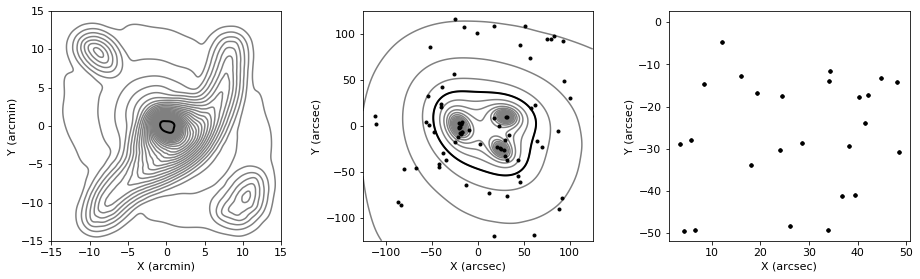

In [7]:
plt.rcParams.update({'font.size': 11})
createMassAndBackProjPlots("truelens.lensdata", False, False, True)

In [8]:
def plotVectors(vectors, angularScale=1, lengthFactor=1, **kwargs):
    
    xCoords, yCoords = [], []
    for cx, cy, vx, vy in vectors:
        length = (vx**2+vy**2)**0.5
        phi = np.arctan2(vy, vx)
        
        xCoords.append((cx/angularScale - length*lengthFactor*np.cos(phi)))
        xCoords.append((cx/angularScale + length*lengthFactor*np.cos(phi)))
        xCoords.append(None)
        yCoords.append((cy/angularScale - length*lengthFactor*np.sin(phi)))
        yCoords.append((cy/angularScale + length*lengthFactor*np.sin(phi)))
        yCoords.append(None)
        
    plt.plot(xCoords, yCoords, '-', **kwargs)
    
def plotShearComponents(thetas, components, lengthFactor, angularScale=1, **kwargs):
    thetas = thetas.reshape((-1,2))
    g1 = components[0].reshape((-1,))
    g2 = components[1].reshape((-1,))
    g = (g1**2 + g2**2)**0.5
    angles = 0.5*np.arctan2(g2,g1)
    vx = g*np.cos(angles)
    vy = g*np.sin(angles)
    vectorField = np.empty((thetas.shape[0],4))
    vectorField[:,:2] = thetas
    vectorField[:,2] = vx
    vectorField[:,3] = vy
    
    plotVectors(vectorField, angularScale=angularScale, lengthFactor=lengthFactor, **kwargs)
    return np.array(vectorField)

def plotShearImgData(imgDat, lengthFactor, angularScale=1, **kwargs):
    thetas, g1, g2 = [], [], []
    for img in imgDat.getAllImagePoints():
        for p in img:
            thetas.append(p["position"])
            g1.append(p["shear"][0])
            g2.append(p["shear"][1])
    plotShearComponents(np.array(thetas), [np.array(g1), np.array(g2)], lengthFactor, angularScale, **kwargs)
    plotStick(V(14,-14)*ANGLE_ARCMIN, lengthFactor, angularScale, **kwargs)
    plt.gca().set_xlabel("X (arcmin)")
    plt.gca().set_ylabel("Y (arcmin)")
    plt.gca().set_aspect("equal")
    
def plotShearFromTextFile(fn, lengthFactor, angularScale=1, **kwargs):
    thetas, g1, g2 = [], [], []
    for l in open(fn):
        if l.startswith("#"):
            continue
        x, y, e1, e2, z = map(float, l.split())
        thetas.append(V(x,y)*ANGLE_ARCSEC)
        g1.append(e1)
        g2.append(e2)
    
    plotShearComponents(np.array(thetas), [np.array(g1), np.array(g2)], lengthFactor, angularScale, **kwargs)
    plotStick(V(14,-14)*ANGLE_ARCMIN, lengthFactor, angularScale, **kwargs)
    plt.gca().set_xlabel("X (arcmin)")
    plt.gca().set_ylabel("Y (arcmin)")
    plt.gca().set_aspect("equal")

def plotStick(stickPos, lengthFactor, angularScale=1, **kwargs):
    plt.plot([stickPos[0]/angularScale],[stickPos[1]/angularScale], 'o', mfc="white", mec="black", ms=35)
    plotShearComponents(np.array(stickPos), [np.array([1]), np.array([0])], lengthFactor, angularScale, **kwargs)


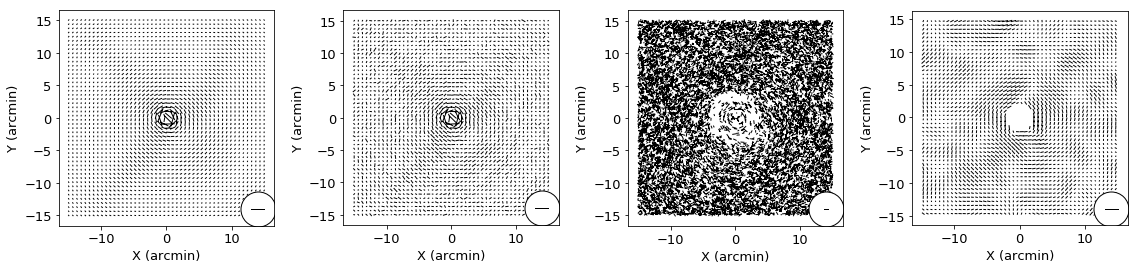

In [9]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plotShearImgData(images.ImagesData.load("shear_mr_48x48_exact_z1.imgdata"), 1, angularScale=ANGLE_ARCMIN, color="black", lw=1)
plt.subplot(1,4,2)
plotShearImgData(images.ImagesData.load("shear_ell_48x48_pointavg_25_z1.imgdata"), 1, angularScale=ANGLE_ARCMIN, color="black", lw=1)
plt.subplot(1,4,3)
plotShearFromTextFile("shearcatalog_redshifs.txt", .3, angularScale=ANGLE_ARCMIN, color="black", lw=1)
plt.subplot(1,4,4)
plotShearImgData(images.ImagesData.load("shear_z1.502_gaussian_48x48_sigma60.000_nocentral120.imgdata"), 1, angularScale=ANGLE_ARCMIN, color="black", lw=1)
plt.tight_layout()

In [10]:
def horCoordFunction(xy):
    return xy[0]

def plotDensAtPosRel(fn, ax = None):
    ax = plt.gca() if ax is None else ax

    savedRealDens = { }
    def saveDens(l, pos, img):
        x = l.getSurfaceMassDensity(pos)
        savedRealDens[tuple(pos)] = x
        return x    
    plotutil.plotDensitiesAtImagePositions(getLIEntry(realLensFileName)["lens"], imgList, marker="x", horCoordFunction=horCoordFunction, axes=False, densFunction=saveDens)
    
    def fracDens(l, pos, imgIdx):
        densReal = savedRealDens[tuple(pos)]
        x = l.getSurfaceMassDensity(pos)
        return x/densReal

    plotutil.plotDensitiesAtImagePositions(getLIEntry(fn)["lens"], imgList, horCoordFunction=horCoordFunction, axes=ax, densFunction=fracDens)
    
    ax.set_ylabel("$\kappa/\kappa_R$")
    xlim = ax.get_xlim()
    ax.plot([-150,150],[1,1],'--',color="gray", lw=1)
    ax.set_xlim(*xlim)

def plotDensAtPos(fn, ax = None):
    ax = plt.gca() if ax is None else ax
    plotutil.plotDensitiesAtImagePositions(getLIEntry(fn)["lens"], imgList, densityUnit=critDens, label="Reconstructed", horCoordFunction=horCoordFunction, axes=ax)
    plotutil.plotDensitiesAtImagePositions(getLIEntry(realLensFileName)["lens"], imgList, densityUnit=critDens, label="True", marker="x", horCoordFunction=horCoordFunction, axes=ax)
    plt.legend()
    ax.set_xlabel("X (arcsec)")
    ax.set_ylabel("$\kappa$")

/home/jori/anaconda3-201812/envs/grale2env201812/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


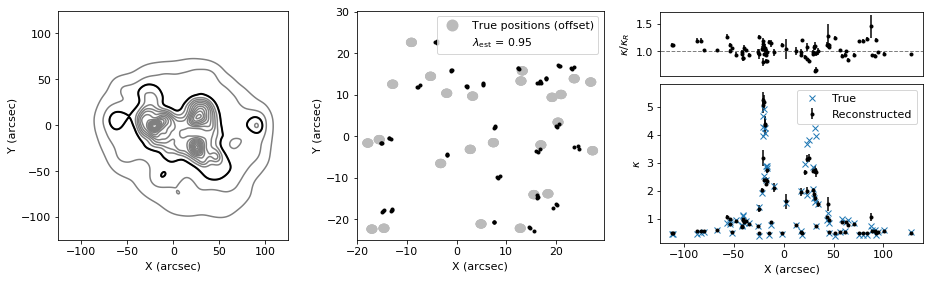

In [11]:
fn = "avgpt-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_noshear-wt_0.1-ws_0-nsd_48-nsz_400-rms_no.lensdata"
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(13,4))
fig = plt.gcf()
plt.subplot(1,3,1)
plotNarrow(fn, False)
plt.subplot(1,3,2)
plotBackproject(fn, True)

ax = fig.add_axes([0.72,0.14,0.28,0.55])
plotDensAtPos(fn, ax)
ax = fig.add_axes([0.72,0.72,0.28,0.22], xticks=[])
plotDensAtPosRel(fn, ax)
#plt.gca().set_ylim([0,6.5])

plt.tight_layout()

Seems like an average of: 20


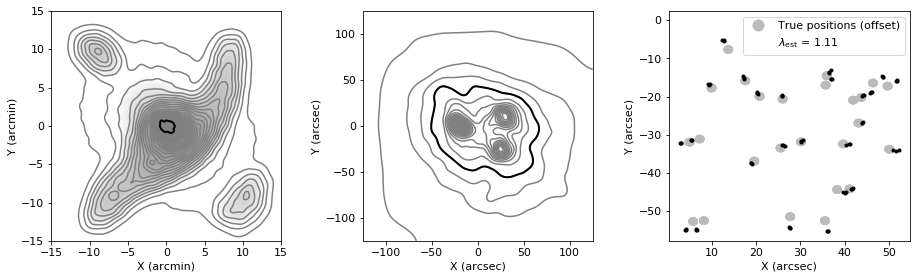

In [12]:
createMassAndBackProjPlots("avgpt-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_mr_48x48_exact_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata") 

Seems like an average of: 20


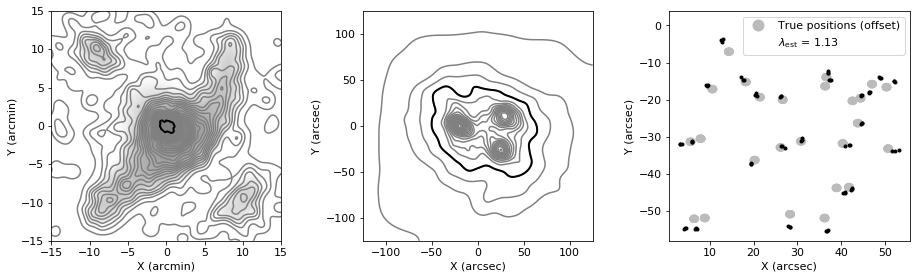

In [13]:
createMassAndBackProjPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_ell_48x48_pointavg_25_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")

Seems like an average of: 20


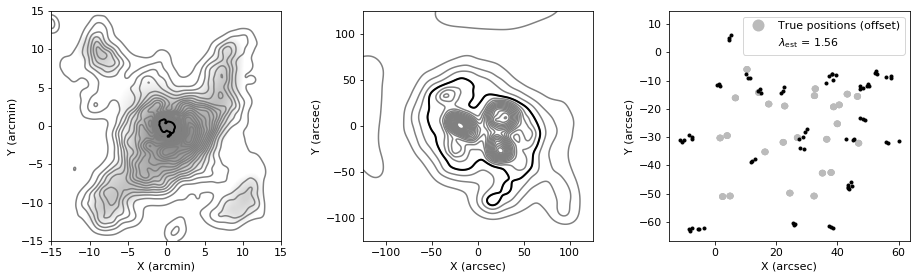

In [14]:
createMassAndBackProjPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_zZ_gaussian_48x48_sigma60.000_nocentral120-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")

In [15]:
def createDensProfilePlots(profiles, narrowOrWide, ax = None, top=None, plotLegend = False):
    ax = plt.gca() if ax is None else ax
    endRadius = 120*ANGLE_ARCSEC if narrowOrWide == "narrow" else 900*ANGLE_ARCSEC
    
    for label, fn, lt, lw in profiles:
        li = getLIEntry(fn)
        plotutil.plotAverageDensityProfile(li[narrowOrWide], densityUnit=critDens, thetaMax=endRadius,
                                              color="black", linestyle=lt, linewidth=lw, label=label, axes=ax)
        
    ax.set_xlabel("Distance from coordinate center (arcsec)")
    ax.set_ylabel("$\kappa$")
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(0,endRadius/ANGLE_ARCSEC)
        
    if plotLegend:
        plt.legend()
        
def createRelDensProfilePlots(profiles, narrowOrWide, ax = None, topBottom=[None, None], plotLegend = False):
    ax = plt.gca() if ax is None else ax
    endRadius = 120*ANGLE_ARCSEC if narrowOrWide == "narrow" else 900*ANGLE_ARCSEC
    
    area = getLIEntry(realLensFileName)[narrowOrWide].getArea()
    realDens = getLIEntry(realLensFileName)[narrowOrWide].getDensityPoints()
    
    for label, fn, lt, lw in profiles:
        if fn == realLensFileName:
            continue
        dens = getLIEntry(fn)[narrowOrWide].getDensityPoints()
        frac = dens/realDens
        di = plotutil.DensInfo(frac, **area)
        plotutil.plotAverageDensityProfile(di, thetaMax=endRadius,
                                              color="black", linestyle=lt, linewidth=lw, label=label, axes=ax)
        
    #ax.set_xlabel("Distance from coordinate center (arcsec)")
    ax.set_ylabel("$\kappa/\kappa_R$")
    ax.set_xlim(0,endRadius/ANGLE_ARCSEC)
    ax.set_ylim(*topBottom)
    ax.plot([0,endRadius/ANGLE_ARCSEC],[1,1],'--',color="gray", lw=1)
        
    if plotLegend:
        plt.legend()

def createIntMassProfilePlots(profiles, ax = None):
    ax = plt.gca() if ax is None else ax
    endRadius = 900*ANGLE_ARCSEC

    for label, fn, lt, lw in profiles:
        li = getLIEntry(fn)
        plotutil.plotIntegratedMassProfile(li["wide"], massUnit=MASS_SUN*1e16, thetaMax=endRadius,
                                              color="black", linestyle=lt, linewidth=lw, label=label, axes=ax)
    ax.set_xlabel("Distance from coordinate center (arcsec)")
    ax.set_ylabel("Interior mass ($10^{16}\;M_\odot)$")

In [16]:
def plotAvgProfilesAndRelProfiles(profiles):
    plt.figure(figsize=(13,4))
    fig = plt.gcf()
    x0, xw = 0.05, 0.26
    y0, y0w = 0.05, 0.6
    y1, y1w = 0.68, 0.22
    ax = fig.add_axes([x0, y0, xw, y0w])
    createDensProfilePlots(profiles, "narrow", ax=ax)
    ax = fig.add_axes([x0, y1, xw, y1w], xticks=[])
    createRelDensProfilePlots(profiles, "narrow", ax=ax)

    x0 = 0.37
    ax = fig.add_axes([x0, y0, xw, y0w])
    createDensProfilePlots(profiles, "wide", ax=ax)
    plt.legend()
    ax = fig.add_axes([x0, y1, xw, y1w], xticks=[])
    createRelDensProfilePlots(profiles, "wide", ax=ax)
    
    x0 = 0.7
    ax = fig.add_axes([x0, y0, xw, 0.85])
    createIntMassProfilePlots(profiles)

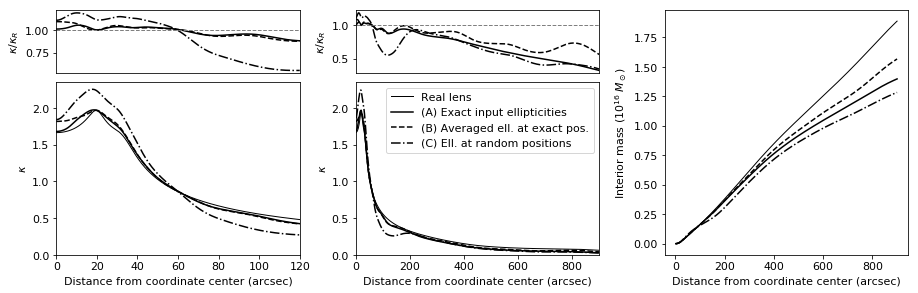

In [17]:
plt.rcParams.update({'font.size': 11})

profileNames = ("Real lens", "(A) Exact input ellipticities", "(B) Averaged ell. at exact pos.",
                "(C) Ell. at random positions")
profileLineTypes = [ "-", "-", "--", "-.", ":" ]
profileWidths = [ 1, 1.5, 1.5, 1.5, 1.5 ]
profilesNoSheet = [ "truelens.lensdata",
                    "avgpt-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_mr_48x48_exact_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata",
                    "avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_ell_48x48_pointavg_25_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata",
                    "avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_zZ_gaussian_48x48_sigma60.000_nocentral120-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata",
                  ]       

profiles = list(zip(profileNames, profilesNoSheet, profileLineTypes, profileWidths))

plt.rcParams.update({'font.size': 11})
plotAvgProfilesAndRelProfiles(profiles)

In [18]:
def addBar(a):
    plt.colorbar(a, fraction=0.046, pad=0.04)

myMap = matplotlib.cm.get_cmap("bwr_r")
myMap = colors.LinearSegmentedColormap.from_list("bwr_half", [ myMap(i/255 + 0.5) for i in range(256) ])

def plotFracRelDens2D(fn, narrowOrWide, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)[narrowOrWide]
    liReal = getLIEntry(realLensFileName)[narrowOrWide]
    
    dens, densReal = li.getDensityPoints(), liReal.getDensityPoints()
    frac = dens/densReal
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    if "sheet_genome" in fn and narrowOrWide == "wide":
        clevels = [1,2,3,4,5,6,7,8,9,10,11,12]
        cmap = myMap
    else:
        clevels = [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
        cmap = "bwr_r"
    norm= colors.BoundaryNorm(clevels, 256)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap=cmap, norm=norm)
    plotutil.plotDensityContours(di, levels=[0.9, 1.1], colors="black", linewidths=[0.75], linestyles=["-","-"])
    ax.set_title("$\kappa/\kappa_R$")

def getMagFromLensPlane(lp, dfrac):
    r = lp.getAlphaVectorDerivatives()
    axx, ayy, axy = r["alpha_xx"]*dfrac, r["alpha_yy"]*dfrac, r["alpha_xy"]*dfrac
    invMag = (1.0-axx)*(1.0-ayy)-axy*axy
    return 1.0/invMag

def plotFracRelMag2D(fn, narrowOrWide, ax=None):
    ax = plt.gca() if ax is None else ax
    li = getLIEntry(fn)[narrowOrWide]
    liReal = getLIEntry(realLensFileName)[narrowOrWide]
    
    zs = 9
    Ds, Dds = cosm.getAngularDiameterDistance(zs), cosm.getAngularDiameterDistance(zd,zs)
    
    mu = getMagFromLensPlane(li.getLensPlane(), Dds/Ds)
    muReal = getMagFromLensPlane(liReal.getLensPlane(), Dds/Ds)
    
    frac = np.log10(abs(mu/muReal))
    #frac = abs(mu/muReal)
    area = li.getArea()
    
    di = plotutil.DensInfo(frac, **area)
    #clevels = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
    clevels = [-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9]
    #clevels = [-1,-0.6,-0.2,0.2,0.6,1]
    norm= colors.BoundaryNorm(clevels, 256)
    plotutil.plotDensity(di,axImgCallback=addBar, cmap="bwr_r",vmin=-1,vmax=1, norm=norm)
    #plotutil.plotDensityContours(di, levels=[-0.2, 0.2], colors="black", linewidths=[0.75], linestyles=["-","-"])
    
    if narrowOrWide == "narrow":
        plotImages()

    ax.set_title("$\log_{10}|\mu/\mu_R|$")

def rel2DPlots_old(fn):
    plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    plotFracRelDens2D(fn, "narrow")
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    plt.subplot(1,4,2)
    plotFracRelMag2D(fn, "narrow")
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().set_xlabel("X (arcsec)")
    plt.subplot(1,4,3)
    plotFracRelDens2D(fn, "wide")
    #plt.gca().get_yaxis().set_ticks([])
    plt.gca().set_ylabel("Y (arcsec)")
    plt.gca().set_xlabel("X (arcsec)")
    plt.subplot(1,4,4)
    plotFracRelMag2D(fn, "wide")
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().set_xlabel("X (arcsec)")
    #plt.tight_layout()
    
def rel2DPlots(fn):
    plt.figure(figsize=(19,4))
    fig = plt.gcf()
    
    xw = 0.18
    y0 = 0.05
    yw = 0.9
    
    fig.add_axes([0.05, y0, xw, yw])
    plotFracRelDens2D(fn, "narrow")
    plt.gca().set_xlabel("X (arcsec)")
    plt.gca().set_ylabel("Y (arcsec)")
    
    fig.add_axes([0.265, y0, xw, yw])
    plotFracRelMag2D(fn, "narrow")
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().set_xlabel("X (arcsec)")
    
    fig.add_axes([0.543, y0, xw, yw])
    plotFracRelDens2D(fn, "wide")
    #plt.gca().get_yaxis().set_ticks([])
    plt.gca().set_ylabel("Y (arcsec)")
    plt.gca().set_xlabel("X (arcsec)")
    
    fig.add_axes([0.75, y0, xw, yw])
    plotFracRelMag2D(fn, "wide")
    plt.gca().get_yaxis().set_ticks([])
    plt.gca().set_xlabel("X (arcsec)")
    #plt.tight_layout()

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

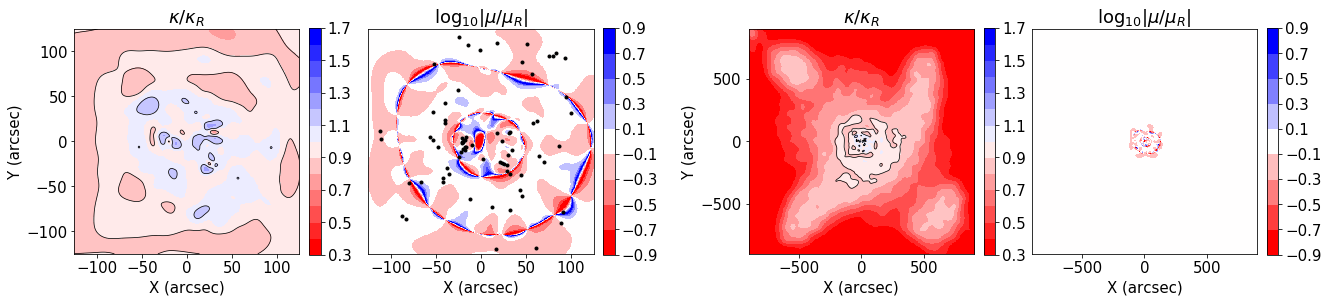

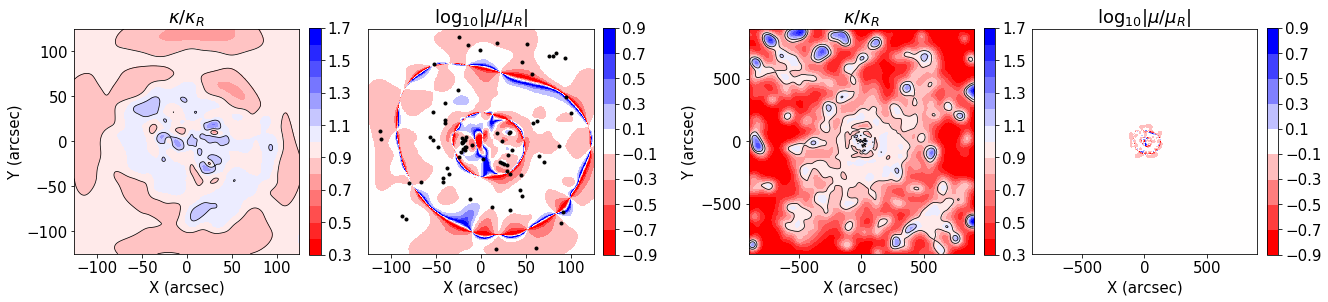

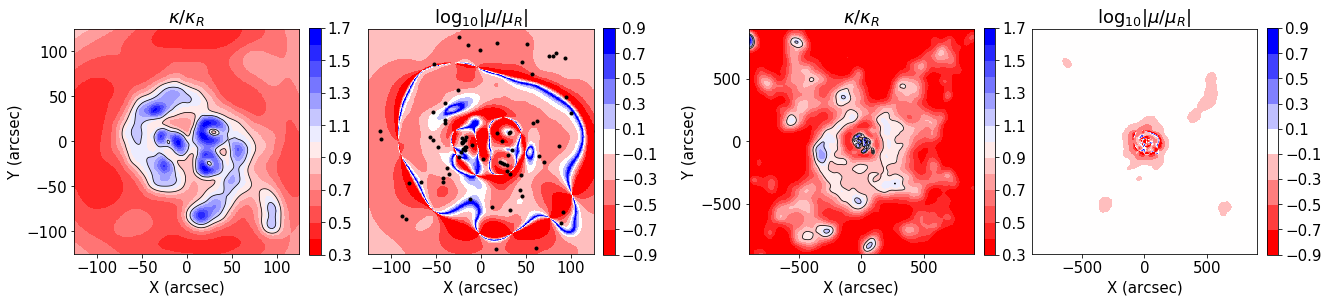

In [19]:
plt.rcParams.update({'font.size': 15})
rel2DPlots("avgpt-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_mr_48x48_exact_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")
rel2DPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_ell_48x48_pointavg_25_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")
rel2DPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_nosheet-wi_shear_zZ_gaussian_48x48_sigma60.000_nocentral120-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")

Seems like an average of: 20


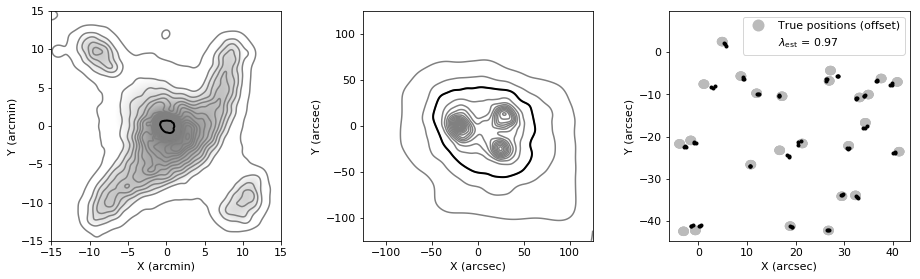

In [20]:
plt.rcParams.update({'font.size': 11})
createMassAndBackProjPlots("avgpt-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_mr_48x48_exact_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")

Seems like an average of: 20


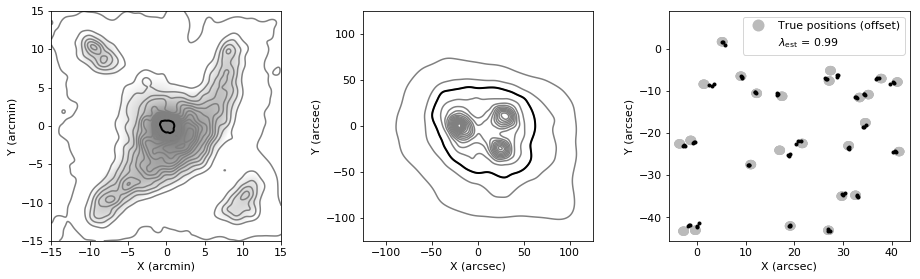

In [21]:
createMassAndBackProjPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_ell_48x48_pointavg_25_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")

Seems like an average of: 20


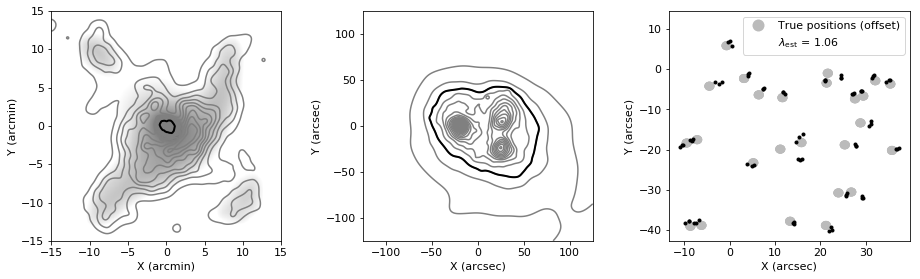

In [22]:
createMassAndBackProjPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_zZ_gaussian_48x48_sigma60.000_nocentral120-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")

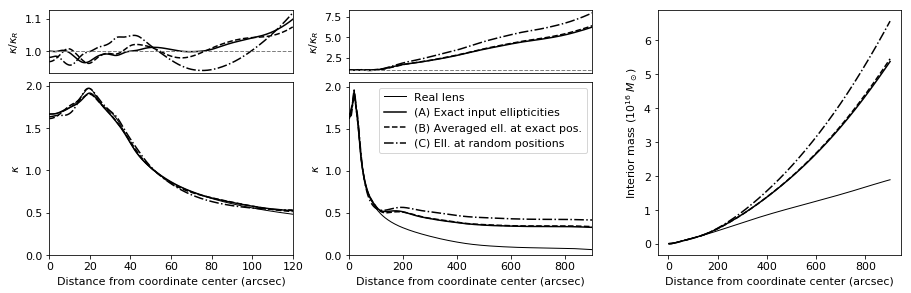

In [23]:
plt.rcParams.update({'font.size': 11})

profileNames = ("Real lens", "(A) Exact input ellipticities", "(B) Averaged ell. at exact pos.",
                "(C) Ell. at random positions")
profileLineTypes = [ "-", "-", "--", "-.", ":" ]
profileWidths = [ 1, 1.5, 1.5, 1.5, 1.5 ]
profilesNoSheet = [ "truelens.lensdata",
                    "avgpt-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_mr_48x48_exact_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata",
                    "avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_ell_48x48_pointavg_25_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata",
                    "avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_zZ_gaussian_48x48_sigma60.000_nocentral120-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata",
                  ]       

profiles = list(zip(profileNames, profilesNoSheet, profileLineTypes, profileWidths))

plotAvgProfilesAndRelProfiles(profiles)

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

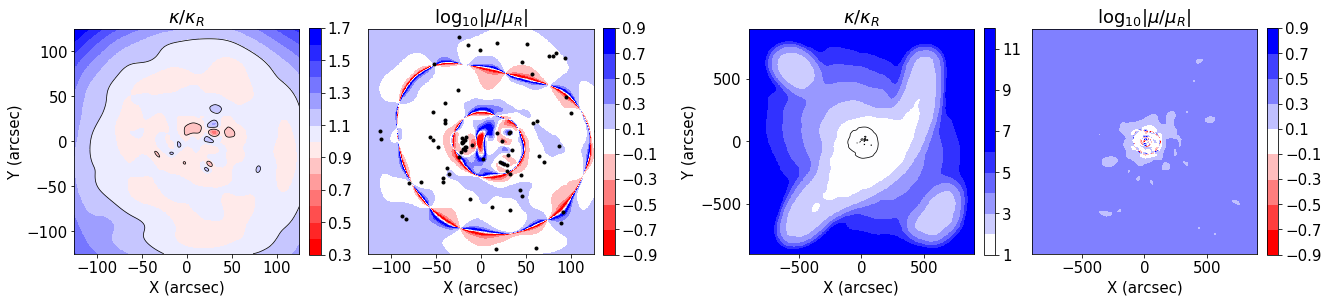

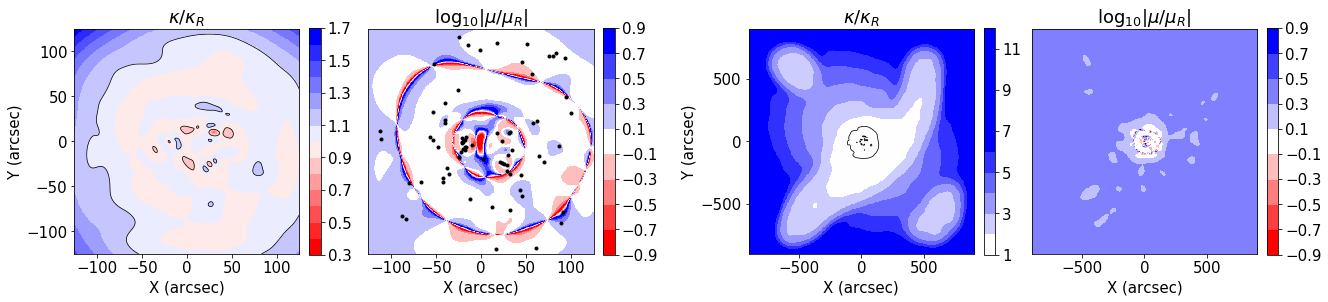

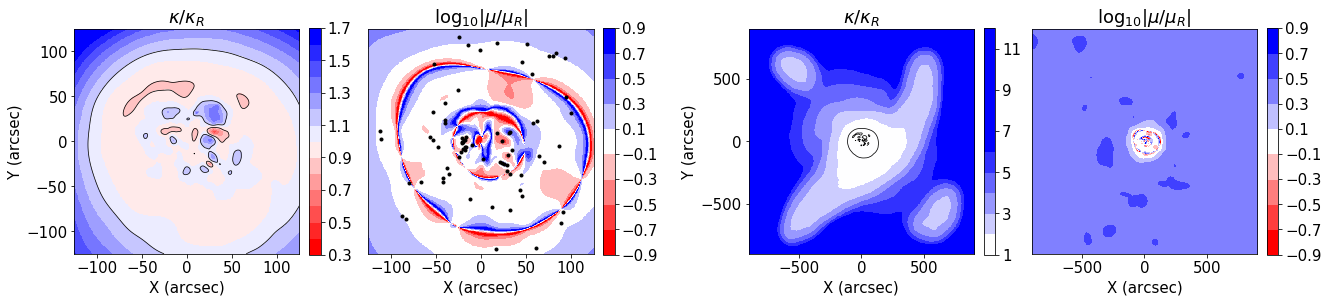

In [24]:
plt.rcParams.update({'font.size': 15})
rel2DPlots("avgpt-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_mr_48x48_exact_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")
rel2DPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_ell_48x48_pointavg_25_zZ-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")
rel2DPlots("avgpt-scaleonweak_no-neg_no-sd_5-lp_no-wm_AveragedEllipticities-sheet_genome-wi_shear_zZ_gaussian_48x48_sigma60.000_nocentral120-wt_0.1-ws_48-nsd_0-nsz_0-rms_no.lensdata")

In [25]:
 #saveCaches()